In [120]:
library(tidyverse)
library(cowplot)
library(patchwork)

library(dplyr)
library(tidyr)
library(purrr)
library(broom)


In [121]:

# List of file paths
file_paths <- c("/home/jpm73279/genome_downloads/C4_markers/count_motifs/file.tsv")

# Read and combine the files
combined_data <- map_df(file_paths, ~read_tsv(.x), .id = "source_file") %>% 
    dplyr::mutate(region_id_unique = str_c(conserved_regions, unique_id, sep = "_"))


Rows: 1098 Columns: 46
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (46): X1, X2, X3, X4, locus, species_other, loci, gene_family, number, a...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [122]:
# Assuming your data frame is named df
spread_wide_tf_counts <- pivot_longer(combined_data, 
                        cols = ARF:ms_CGTCGTCGT, 
                        names_to = "TF", 
                        values_to = "TF_value") %>% 
    dplyr::mutate(tf_count_binary = case_when(TF_value > 0 ~ 1, 
                                             TF_value == 0 ~ 0))


In [123]:
colnames(spread_wide_tf_counts)

[1] "source_file"       "X1"                "X2"               
 [4] "X3"                "X4"                "locus"            
 [7] "species_other"     "loci"              "gene_family"      
[10] "number"            "acr_id"            "score"            
[13] "X10"               "species"           "geneID"           
[16] "enzyme_location"   "conserved_regions" "unique_id"        
[19] "acr_class_type"    "region_id_unique"  "TF"               
[22] "TF_value"          "tf_count_binary"

In [124]:

# Perform operations in a single pipeline
fischer_test_all_tfs_agnostic <- spread_wide_tf_counts %>%
  dplyr::filter(species != "species") %>% 
  group_by(species, TF) %>%
  group_split() %>%
  
  map_dfr(function(df) {
    table <- xtabs(~conserved_regions + tf_count_binary, data = df)
    if (all(dim(table) == c(2, 2))) {
      test_result <- fisher.test(table)
      tidy_result <- broom::tidy(test_result)
      return(tibble(
        species = unique(df$species),
        TF = unique(df$TF),
        #acr_class_type = unique(df$acr_class_type),
        p.value = tidy_result$p.value,
        estimate = tidy_result$estimate,
        conf.low = tidy_result$conf.low,
        conf.high = tidy_result$conf.high
      ))
    } else {
      return(tibble(
        species = unique(df$species),
        TF = unique(df$TF),
        #acr_class_type = unique(df$acr_class_type),
        p.value = NA_real_,
        estimate = NA_real_,
        conf.low = NA_real_,
        conf.high = NA_real_
      ))
    }
  })

# results_df now contains a tidy tibble with the results


In [125]:
fischer_test_all_tfs_agnostic %>% 
    #dplyr::filter(p.value < .05) %>% 
    dplyr::filter(str_starts(TF, "ms_") | str_starts(TF, "bs_")) 



species,TF,p.value,estimate,conf.low,conf.high
<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Os,bs_CATG,5.498434e-02,4.2506374,0.9189469,40.119495
Os,bs_DOF,1.014056e-06,20.6930520,4.4425322,196.049060
Os,bs_GCCGCC,1.000000e+00,1.1578817,0.3751250,3.816535
Os,ms_AGCTA,1.534365e-01,3.1347093,0.6704462,29.768223
Os,ms_CGTCGTCGT,4.501664e-01,0.6386707,0.1940418,1.966293
Os,ms_GACA,2.677697e-01,2.4493129,0.6321616,14.061940
Os,ms_GACGA,8.029462e-01,0.8607032,0.2781314,2.662496
Pm,bs_CATG,1.274514e-01,1.5689681,0.8579209,2.957776
Pm,bs_DOF,6.662488e-06,3.2408191,1.8723852,5.723906


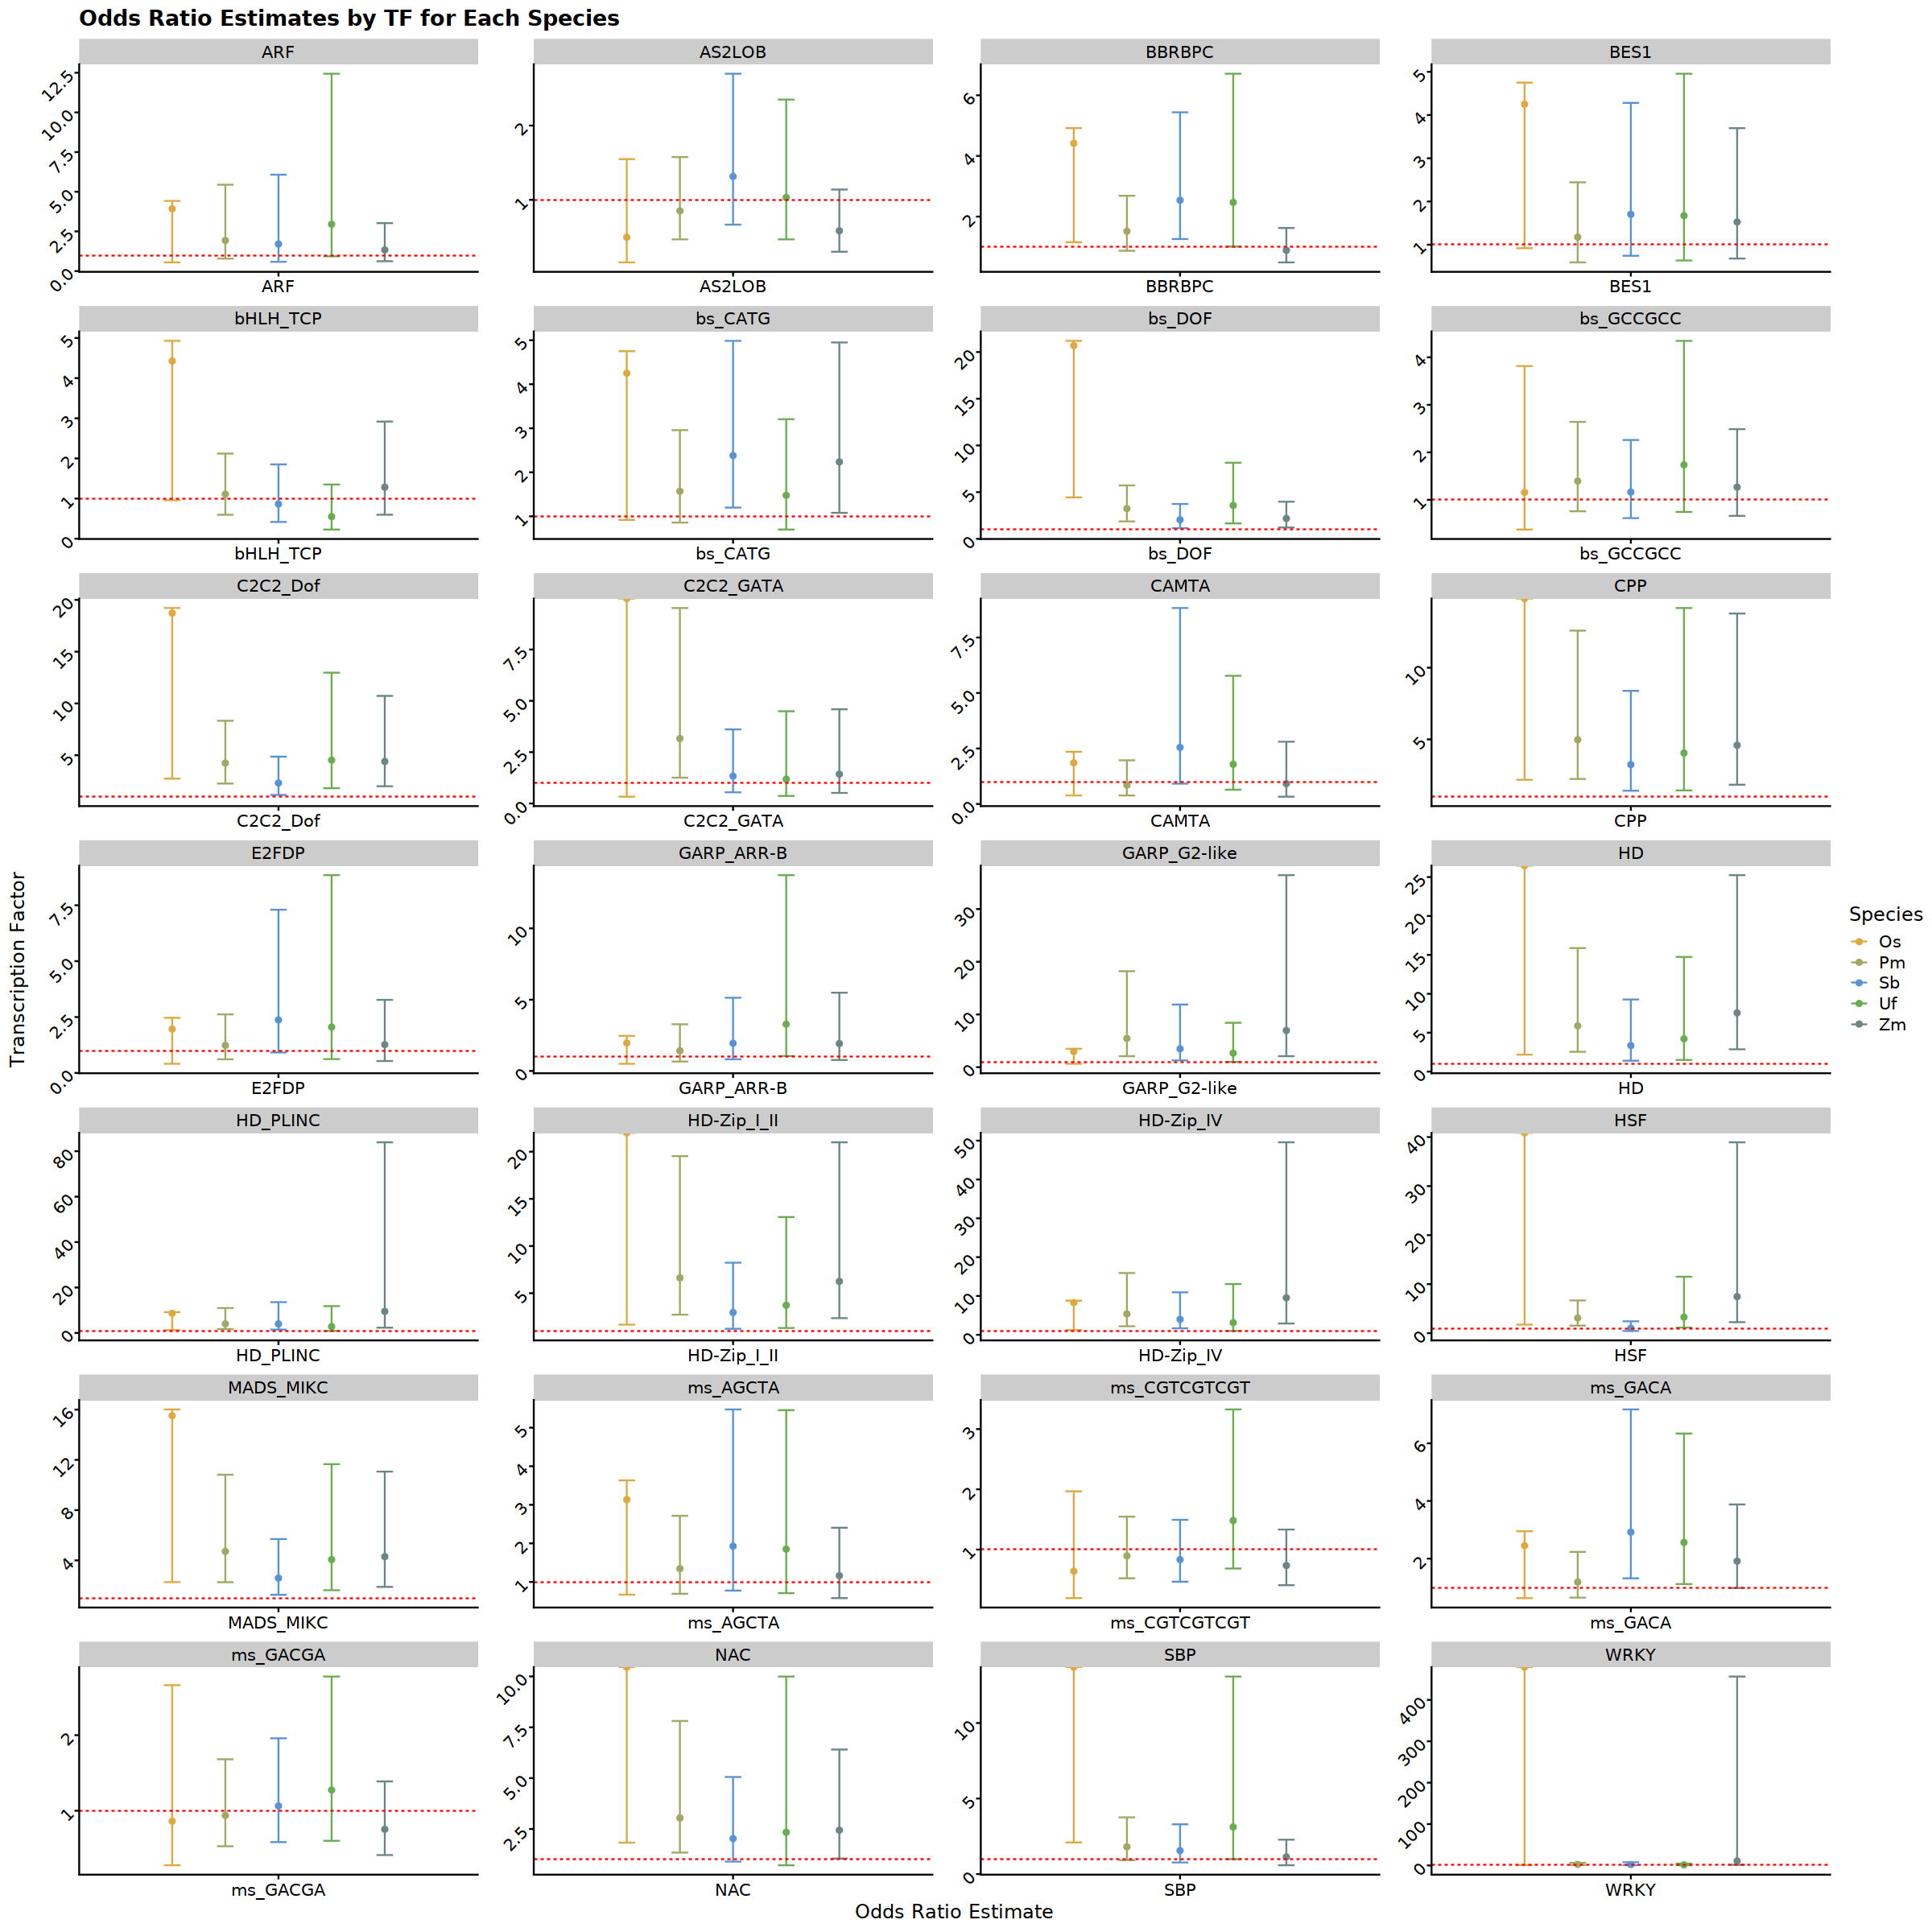

In [126]:
library(ggplot2)

umap_cluster_colors <- c("#DEA940", "#A2A763", "#5894D4", "#6AAD51", "#6C8686", "#FFD92F", "#7f2201", "#b53310",
                         "#E7673B", "#FB9A99", "#E31A1C", "#FDBF6F", "#CAB2D6", "#386CB0", "#FFFFB3", "#5dead5", "#c11577",
                         "#CCCCCC", "#7570B3", "#B15928", "#6A3D9A", "#d87c6a", "#0060e8", "#84c5ff", "#ffd460", "#d81397",
                         "#4d908e", "#b088f9", "#800020", "#30D5C8")


options(repr.plot.width=20, repr.plot.height=20)
fischer_test_all_tfs_agnostic %>% 
    dplyr::mutate(conf.high = case_when(species == "Os" & conf.high > 5 ~ estimate + .5,
                                       TRUE ~ conf.high)) %>% 
  ggplot(., aes(x = TF, y = estimate, color = species)) +
  geom_point(position = position_dodge(width = 0.8)) +
  geom_errorbar(aes(ymin = conf.low, ymax = conf.high), position = position_dodge(width = 0.8), width = 0.25) +
  theme_cowplot() + 
   geom_hline(yintercept = 1, linetype = "dashed", color = "red") +  # Adds a red dashed line at y=1
  #coord_flip() +  # Flips the coordinates
  theme(axis.text.y = element_text(angle = 45, hjust = 1)) +  # Adjust text angle for y-axis
  labs(title = "Odds Ratio Estimates by TF for Each Species",
       y = "Transcription Factor",  # Flipped, so y is now the TF
       x = "Odds Ratio Estimate",   # Flipped, so x is now the estimate
       color = "Species") +
  #coord_cartesian(ylim = c(0, 5)) +  # Adjust as necessary
  facet_wrap(.~TF, scales = "free", nrow = 7 , ncol = 4) + 
  scale_color_manual(values = umap_cluster_colors)



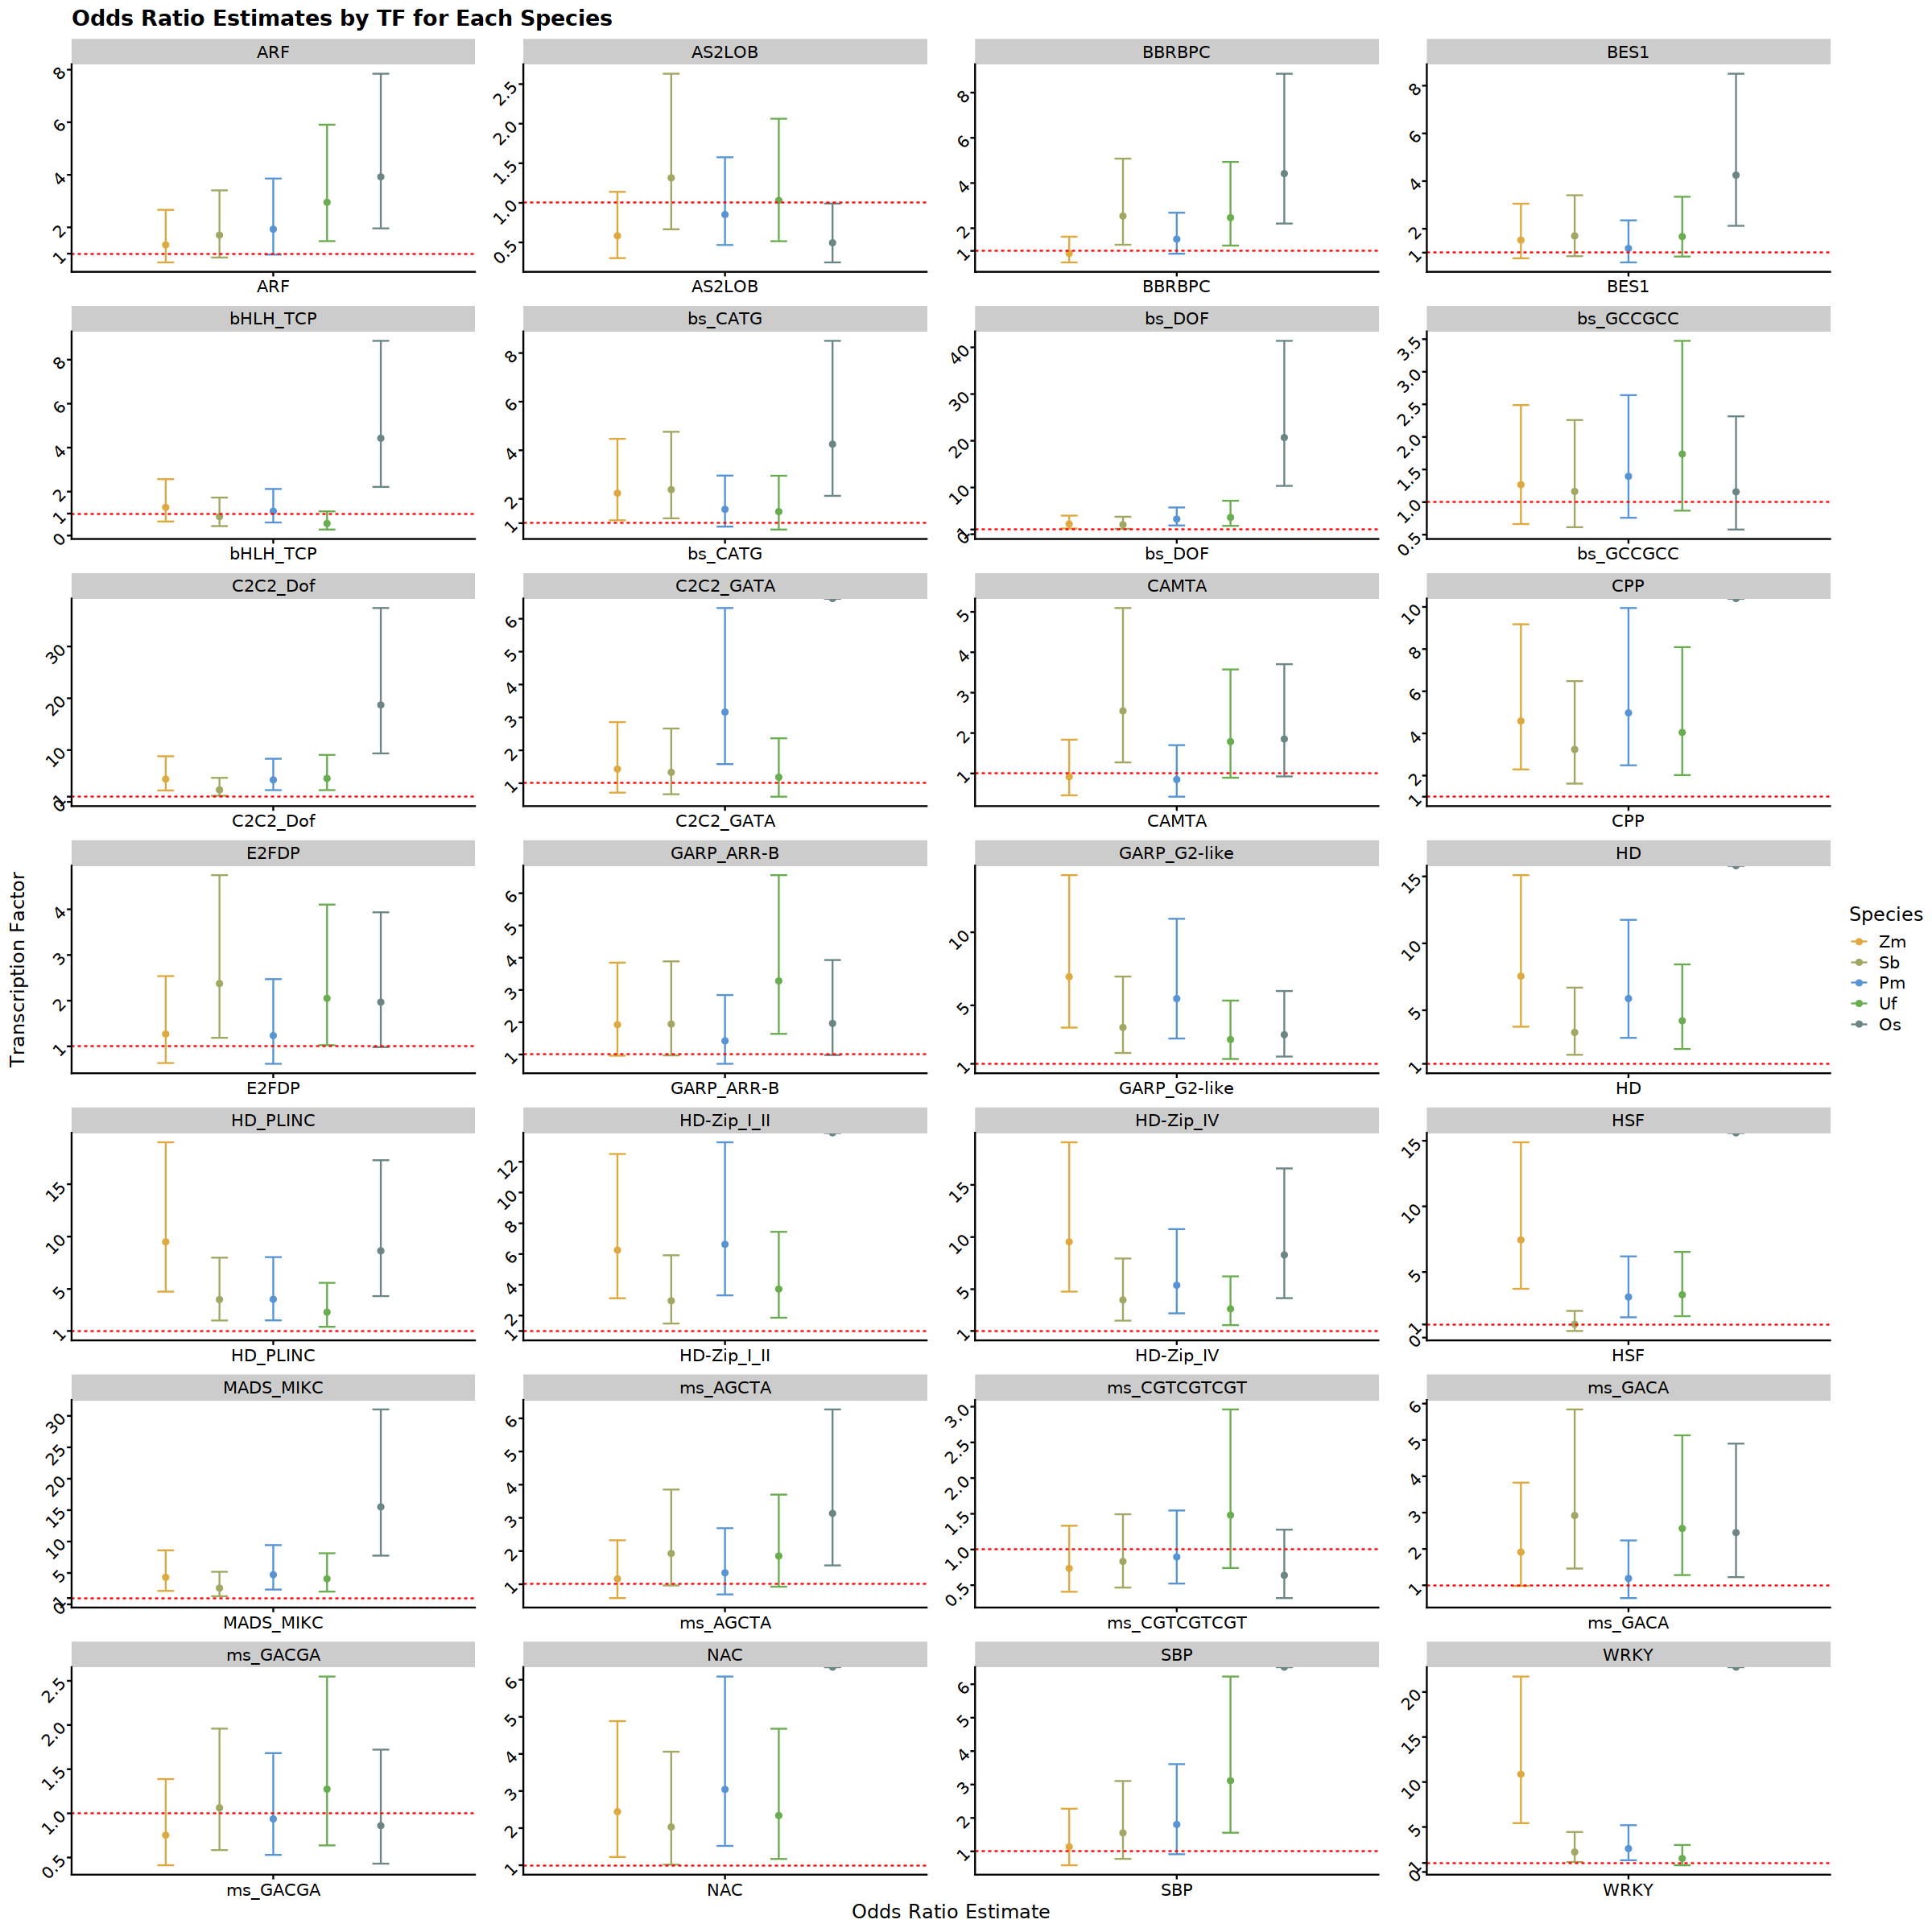

In [127]:
library(dplyr)
library(ggplot2)
library(forcats)

# Cap multiplier for confidence intervals
cap_multiplier <- 2

# Adjusting the confidence intervals
fischer_test_all_tfs_agnostic <- fischer_test_all_tfs_agnostic %>%
  mutate(
    conf.high = pmin(conf.high, estimate * cap_multiplier),
    conf.low = pmax(conf.low, estimate / cap_multiplier),
    species = fct_relevel(species, "Zm", "Sb", "Pm", "Uf", "Os")
  )

# Plotting
options(repr.plot.width=20, repr.plot.height=20)

plotting_odds_ratio <- ggplot(fischer_test_all_tfs_agnostic, aes(x = TF, y = estimate, color = species)) +
  geom_point(position = position_dodge(width = 0.8)) +
  geom_errorbar(aes(ymin = conf.low, ymax = conf.high), position = position_dodge(width = 0.8), width = 0.25) +
  theme_cowplot() +
  geom_hline(yintercept = 1, linetype = "dashed", color = "red") +
  scale_y_continuous(breaks = function(x) unique(c(1, pretty(x)))) +  # Ensure y-axis break at 1
  theme(axis.text.y = element_text(angle = 45, hjust = 1)) +
  labs(title = "Odds Ratio Estimates by TF for Each Species",
       y = "Transcription Factor",
       x = "Odds Ratio Estimate",
       color = "Species") +
  facet_wrap(.~TF, scales = "free", nrow = 7 , ncol = 4) +
  scale_color_manual(values = umap_cluster_colors)

# To display the plot
plotting_odds_ratio


ggsave(plot = plotting_odds_ratio, file = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_6/motif_OR/all_species.OR.pdf",
       width = 8,
       height = 14 )

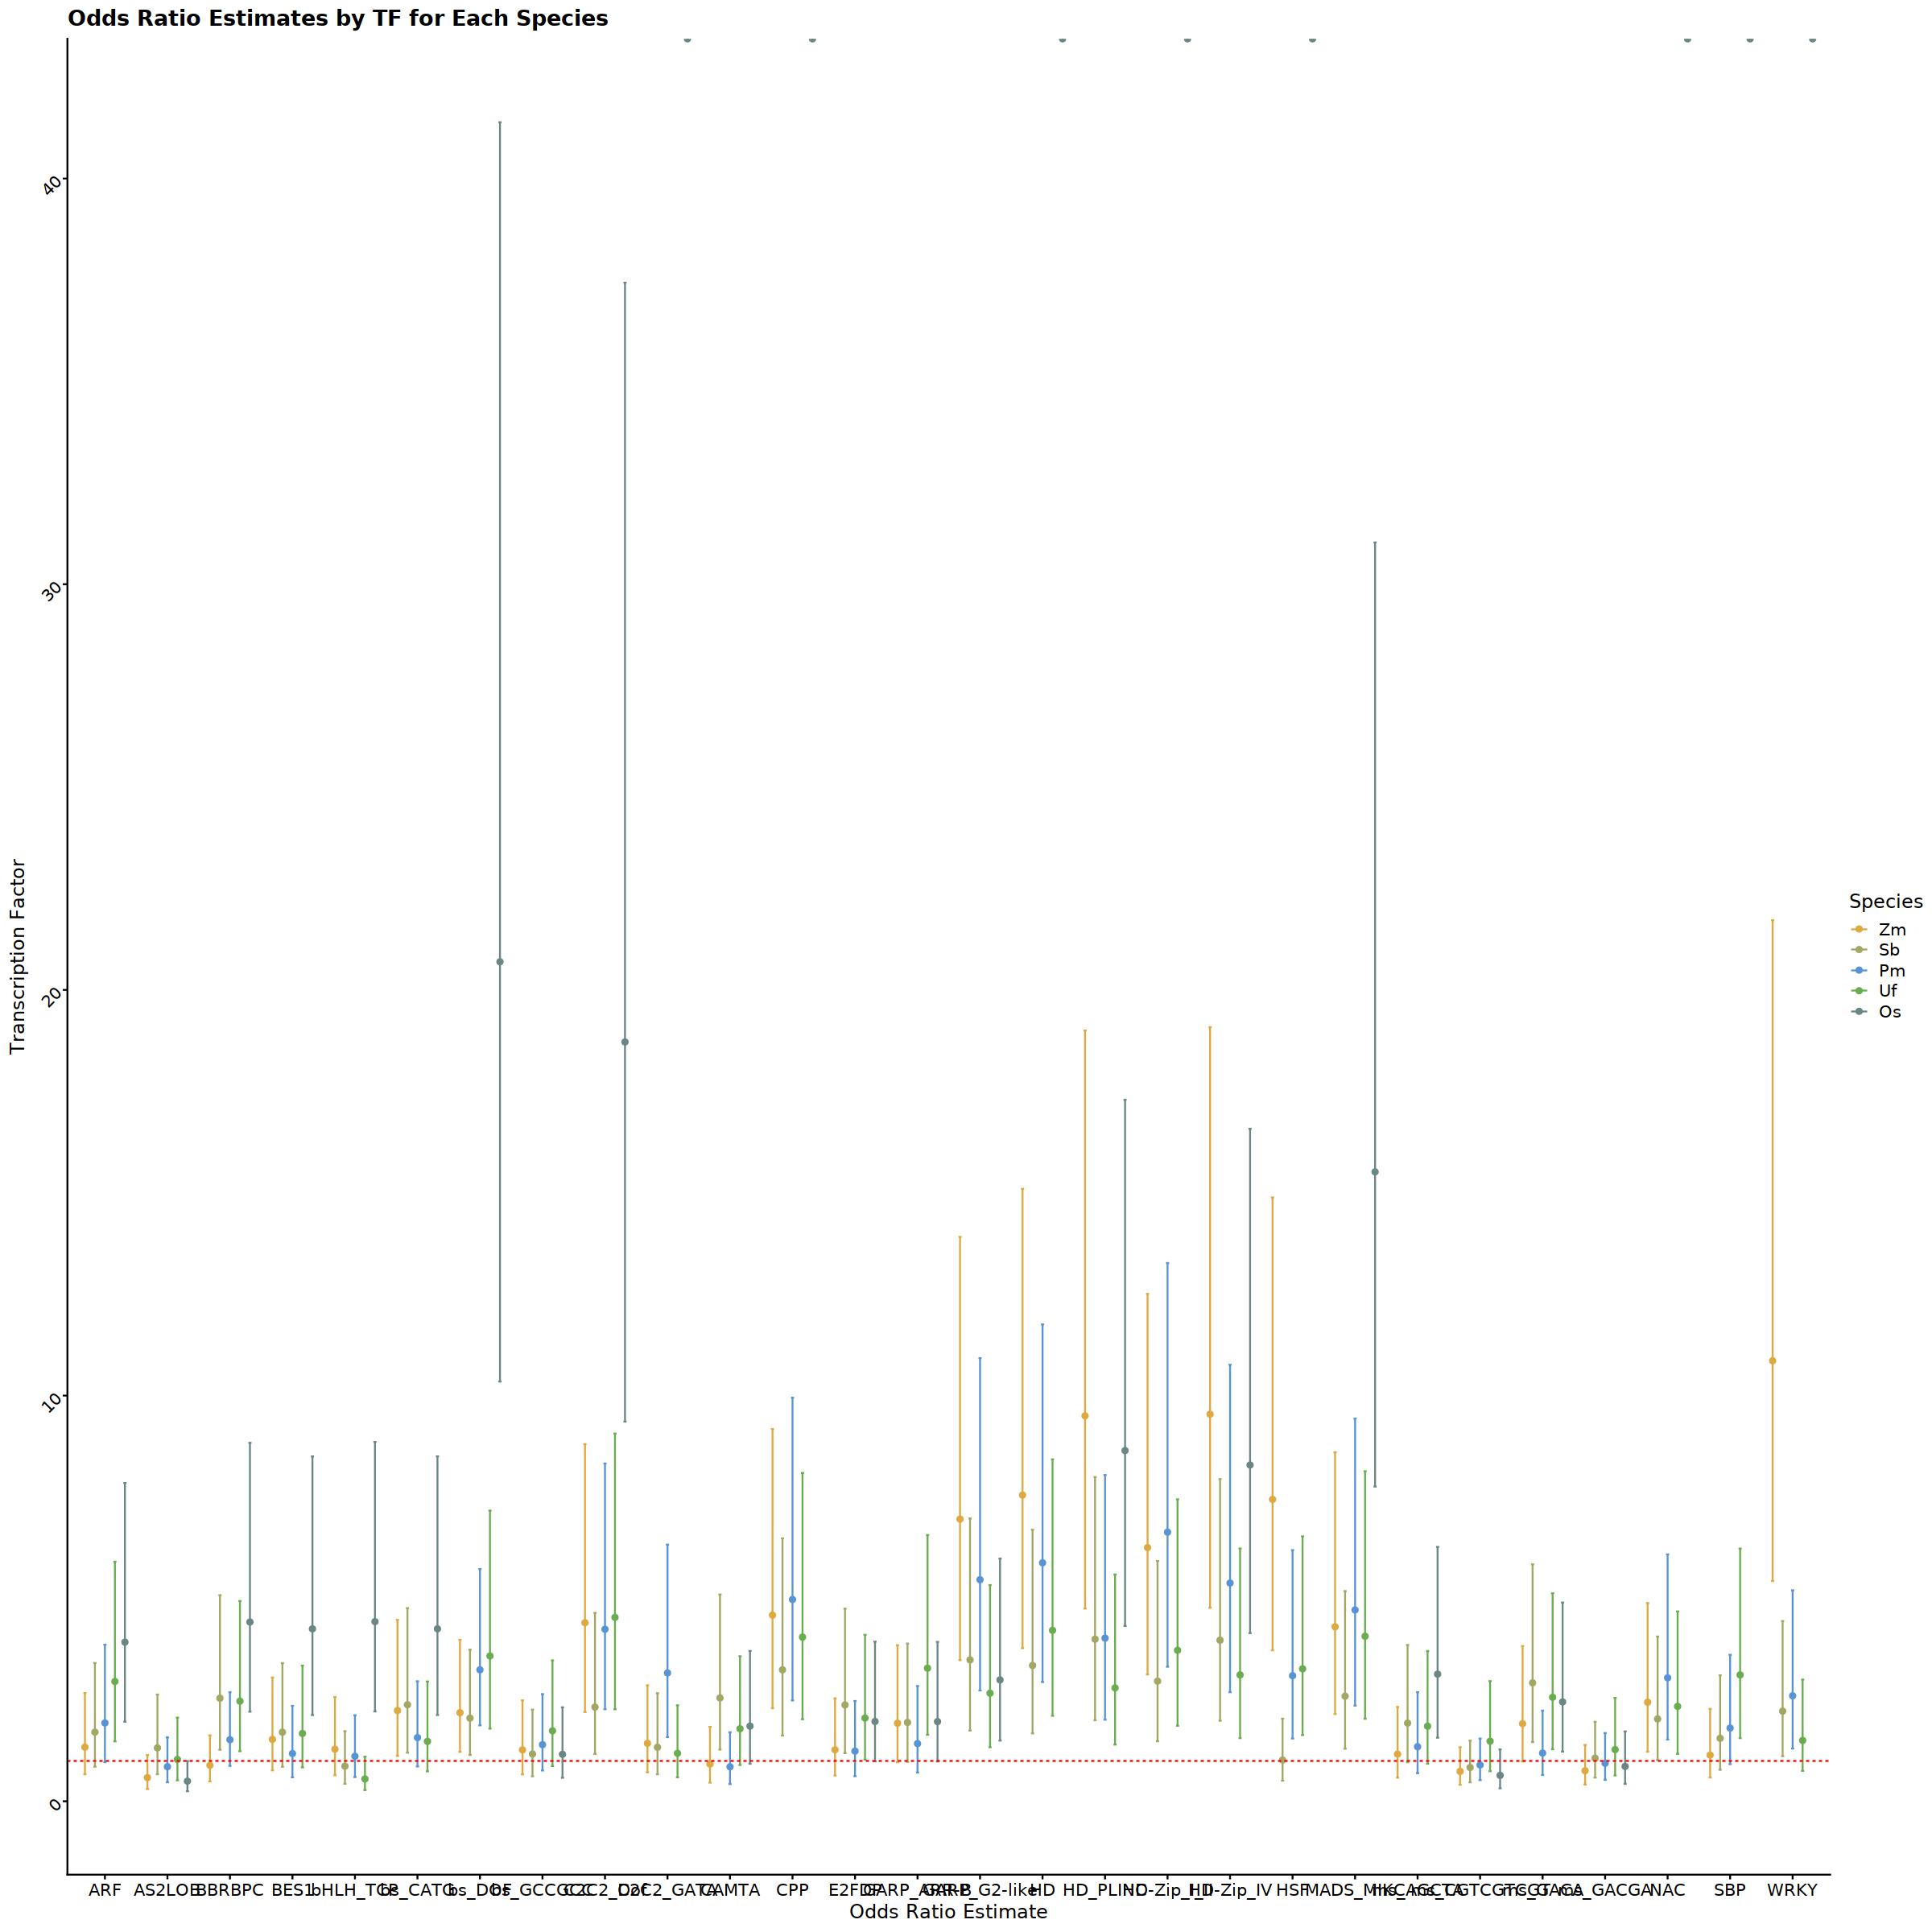

In [128]:
library(dplyr)
library(ggplot2)
library(forcats)

# Cap multiplier for confidence intervals
cap_multiplier <- 2

# Adjusting the confidence intervals
fischer_test_all_tfs_agnostic <- fischer_test_all_tfs_agnostic %>%
  mutate(
    conf.high = pmin(conf.high, estimate * cap_multiplier),
    conf.low = pmax(conf.low, estimate / cap_multiplier),
    species = fct_relevel(species, "Zm", "Sb", "Pm", "Uf", "Os")
  )

# Plotting
options(repr.plot.width=20, repr.plot.height=20)
plotting_odds_ratio <- ggplot(fischer_test_all_tfs_agnostic, aes(x = TF, y = estimate, color = species)) +
  geom_point(position = position_dodge(width = 0.8)) +
  geom_errorbar(aes(ymin = conf.low, ymax = conf.high), position = position_dodge(width = 0.8), width = 0.25) +
  theme_cowplot() +
  geom_hline(yintercept = 1, linetype = "dashed", color = "red") +
  theme(axis.text.y = element_text(angle = 45, hjust = 1)) +
  labs(title = "Odds Ratio Estimates by TF for Each Species",
       y = "Transcription Factor",
       x = "Odds Ratio Estimate",
       color = "Species") +
  scale_color_manual(values = umap_cluster_colors)

plotting_odds_ratio

In [89]:
length(unique(fischer_test_all_tfs_agnostic$TF))

[1] 28

In [141]:
# Load necessary libraries
library(dplyr)
library(tidyr)
library(purrr)
library(broom)

# Assuming spread_wide_tf_counts is your data frame

# Perform operations in a single pipeline
contingency_by_acr_type <- spread_wide_tf_counts %>%
  dplyr::filter(species != "species") %>% 
  group_by(species, TF, acr_class_type) %>%
  group_split() %>%
  map_dfr(function(df) {
    table <- xtabs(~conserved_regions + tf_count_binary, data = df)
    if (all(dim(table) == c(2, 2))) {
      test_result <- fisher.test(table)
      tidy_result <- broom::tidy(test_result)
      return(tibble(
        species = unique(df$species),
        TF = unique(df$TF),
        acr_class_type = unique(df$acr_class_type),
        p.value = tidy_result$p.value,
        estimate = tidy_result$estimate,
        conf.low = tidy_result$conf.low,
        conf.high = tidy_result$conf.high
      ))
    } else {
      return(tibble(
        species = unique(df$species),
        TF = unique(df$TF),
        acr_class_type = unique(df$acr_class_type),
        p.value = NA_real_,
        estimate = NA_real_,
        conf.low = NA_real_,
        conf.high = NA_real_
      ))
    }
  })

# results_df now contains a tidy tibble with the results




In [142]:
contingency_by_acr_type %>% 
    dplyr::filter(p.value < .05) %>% 
    dplyr::filter(str_starts(TF, "ms_") | str_starts(TF, "bs_")) 



species,TF,acr_class_type,p.value,estimate,conf.low,conf.high
<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Os,bs_DOF,broadly_accessible,0.0002217816,13.65071691,2.621763748,137.919216
Os,bs_DOF,mesophyll,0.0108695652,Inf,1.388152139,Inf
Os,bs_GCCGCC,mesophyll,0.0276679842,0.07715223,0.001279903,1.043198
Pm,bs_DOF,broadly_accessible,0.0261903862,2.13985623,1.086664217,4.288592
Pm,bs_DOF,bundle_sheath,0.0009968660,18.19397991,2.315886474,840.182693
Pm,bs_DOF,mesophyll,0.0077573869,5.07551054,1.349589284,24.272978
Sb,bs_CATG,broadly_accessible,0.0240689588,2.44286114,1.092522936,5.922775
Sb,bs_DOF,broadly_accessible,0.0186641506,2.16835227,1.096221640,4.399042
Sb,ms_GACA,broadly_accessible,0.0102493189,3.02069660,1.222248158,8.569974


In [132]:
colnames(spread_wide_tf_counts)

[1] "source_file"       "X1"                "X2"               
 [4] "X3"                "X4"                "locus"            
 [7] "species_other"     "loci"              "gene_family"      
[10] "number"            "acr_id"            "score"            
[13] "X10"               "species"           "geneID"           
[16] "enzyme_location"   "conserved_regions" "unique_id"        
[19] "acr_class_type"    "region_id_unique"  "TF"               
[22] "TF_value"          "tf_count_binary"

In [138]:
# Load necessary libraries
library(dplyr)
library(tidyr)
library(purrr)
library(broom)

# Assuming spread_wide_tf_counts is your data frame

# Perform operations in a single pipeline
contingency_by_enzyme_type <- spread_wide_tf_counts %>%
  dplyr::filter(species != "species") %>% 
  group_by(species, TF, enzyme_location) %>%
  group_split() %>%
  map_dfr(function(df) {
    table <- xtabs(~conserved_regions + tf_count_binary, data = df)
    if (all(dim(table) == c(2, 2))) {
      test_result <- fisher.test(table)
      tidy_result <- broom::tidy(test_result)
      return(tibble(
        species = unique(df$species),
        TF = unique(df$TF),
        enzyme_location = unique(df$enzyme_location),
        p.value = tidy_result$p.value,
        estimate = tidy_result$estimate,
        conf.low = tidy_result$conf.low,
        conf.high = tidy_result$conf.high
      ))
    } else {
      return(tibble(
        species = unique(df$species),
        TF = unique(df$TF),
        enzyme_location = unique(df$enzyme_location),
        p.value = NA_real_,
        estimate = NA_real_,
        conf.low = NA_real_,
        conf.high = NA_real_
      ))
    }
  })

# results_df now contains a tidy tibble with the results


Warning message:
“Removed 4 rows containing missing values (`geom_point()`).”


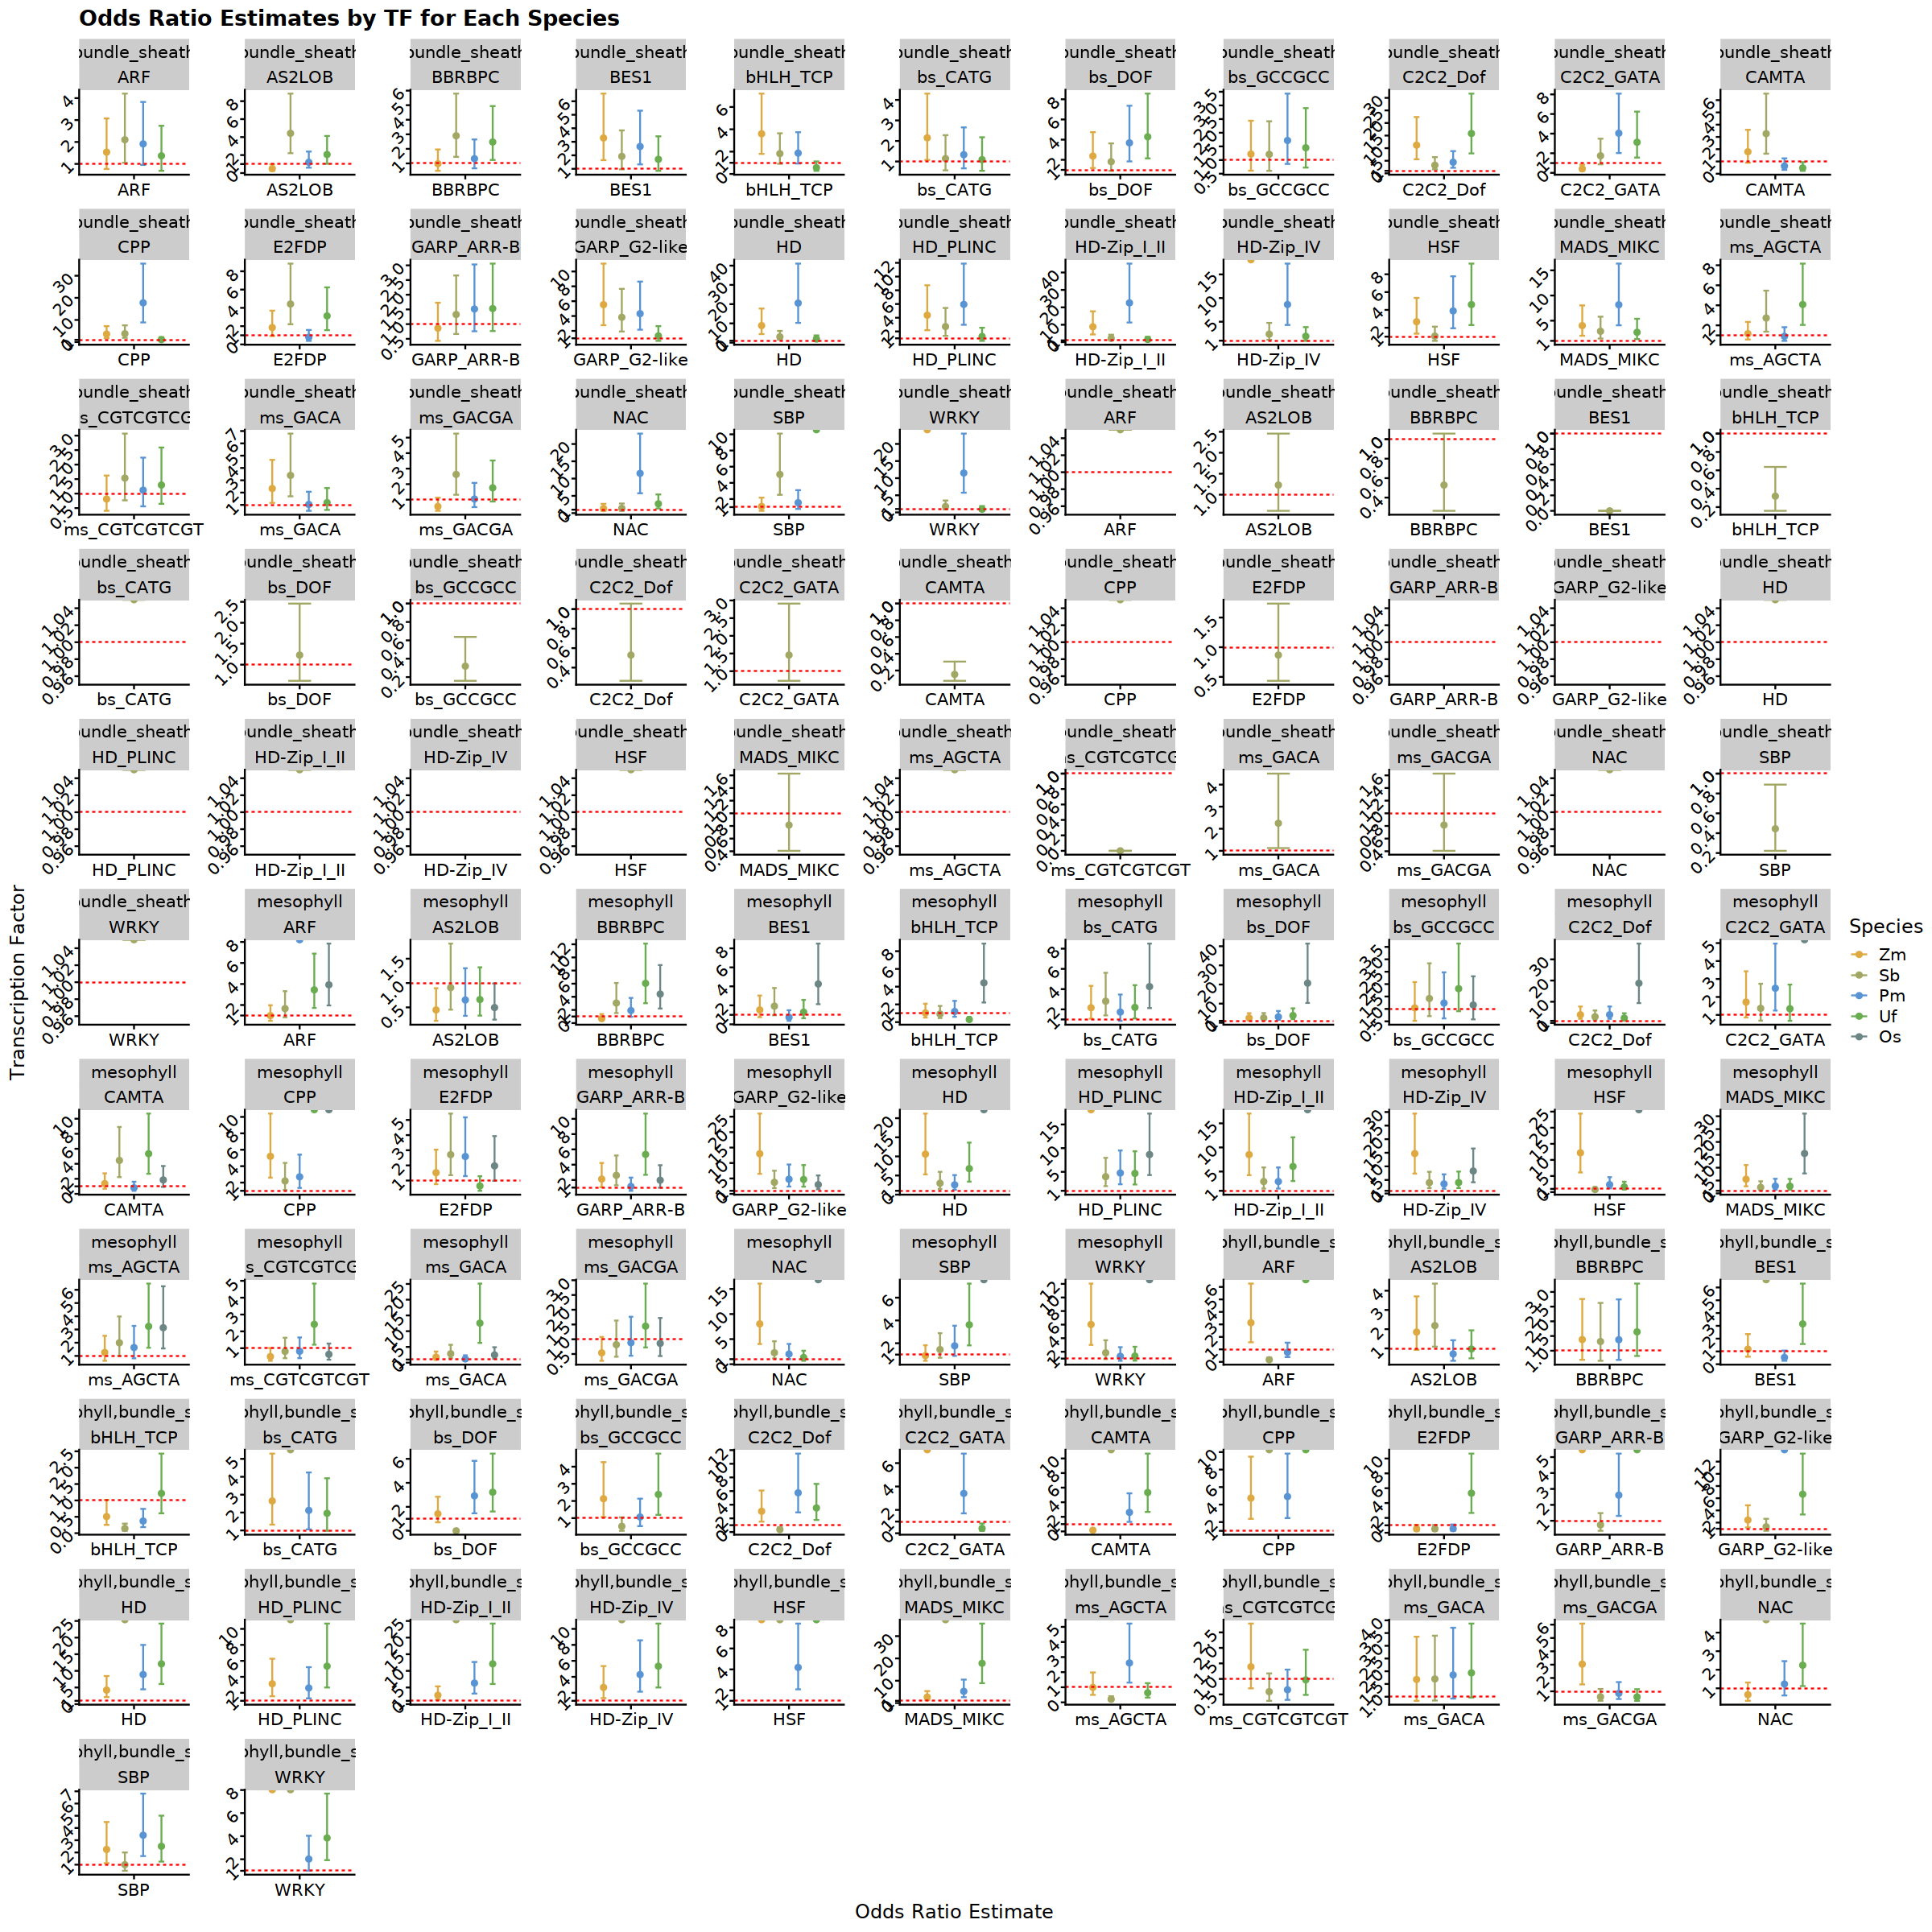

In [139]:
library(dplyr)
library(ggplot2)
library(forcats)

# Cap multiplier for confidence intervals
cap_multiplier <- 2

# Adjusting the confidence intervals
contingency_by_enzyme_type <- contingency_by_enzyme_type %>%
  mutate(
    conf.high = pmin(conf.high, estimate * cap_multiplier),
    conf.low = pmax(conf.low, estimate / cap_multiplier),
    species = fct_relevel(species, "Zm", "Sb", "Pm", "Uf", "Os")
  )

# Plotting
options(repr.plot.width=20, repr.plot.height=20)

ggplot(contingency_by_enzyme_type, aes(x = TF, y = estimate, color = species)) +
  geom_point(position = position_dodge(width = 0.8)) +
  geom_errorbar(aes(ymin = conf.low, ymax = conf.high), position = position_dodge(width = 0.8), width = 0.25) +
  theme_cowplot() +
  geom_hline(yintercept = 1, linetype = "dashed", color = "red") +
  scale_y_continuous(breaks = function(x) unique(c(1, pretty(x)))) +  # Ensure y-axis break at 1
  theme(axis.text.y = element_text(angle = 45, hjust = 1)) +
  labs(title = "Odds Ratio Estimates by TF for Each Species",
       y = "Transcription Factor",
       x = "Odds Ratio Estimate",
       color = "Species") +
  facet_wrap(enzyme_location~TF, scales = "free") +
  scale_color_manual(values = umap_cluster_colors)

